In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


         user_name         user_location  ...               source is_retweet
0           ᏉᎥ☻լꂅϮ            astroworld  ...   Twitter for iPhone      False
1    Tom Basile 🇺🇸          New York, NY  ...  Twitter for Android      False
2  Time4fisticuffs      Pewee Valley, KY  ...  Twitter for Android      False
3      ethel mertz  Stuck in the Middle   ...   Twitter for iPhone      False
4         DIPR-J&K     Jammu and Kashmir  ...  Twitter for Android      False

[5 rows x 13 columns]
                     user_name  ... is_retweet
179103  AJIMATI AbdulRahman O.  ...      False
179104                   Jason  ...      False
179105             BEEHEMOTH ⏳  ...      False
179106           Gary DelPonte  ...      False
179107                 TUKY II  ...      False

[5 rows x 13 columns]
       user_followers   user_friends  user_favourites
count    1.791080e+05  179108.000000     1.791080e+05
mean     1.090555e+05    2121.701566     1.444411e+04
std      8.414670e+05    9162.553072     4

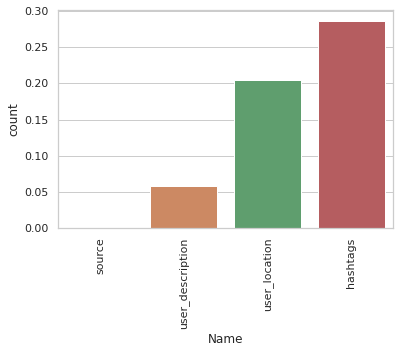

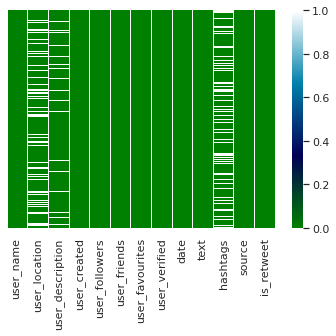

            Features  Uniques
0          user_name    92276
1      user_location    26920
2   user_description    89200
3       user_created    93708
4     user_followers    27694
5       user_friends    11022
6    user_favourites    35259
7      user_verified        2
8               date   136611
9               text   178683
10          hashtags    52640
11            source      610
12        is_retweet        1


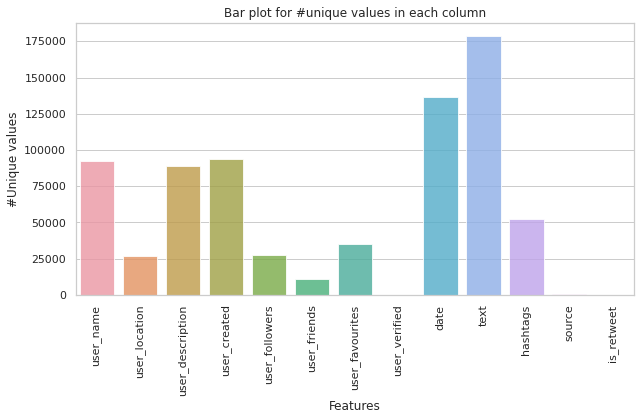

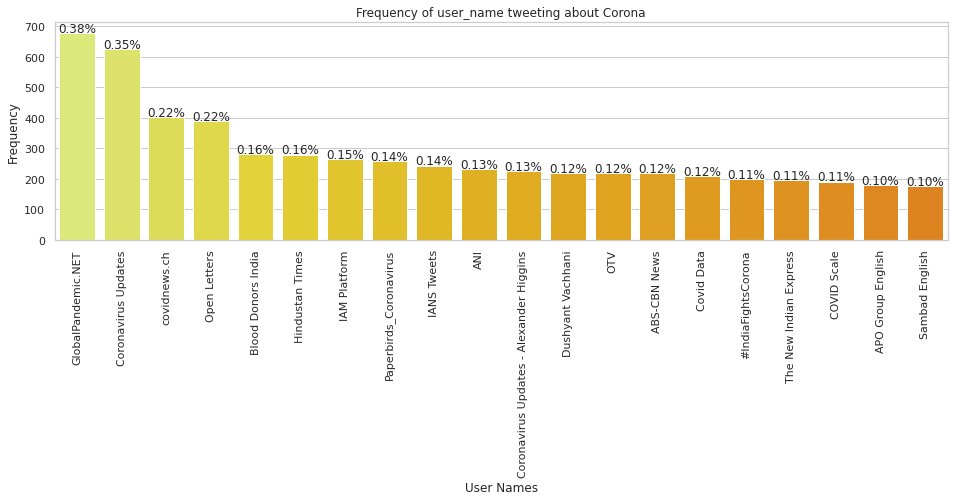

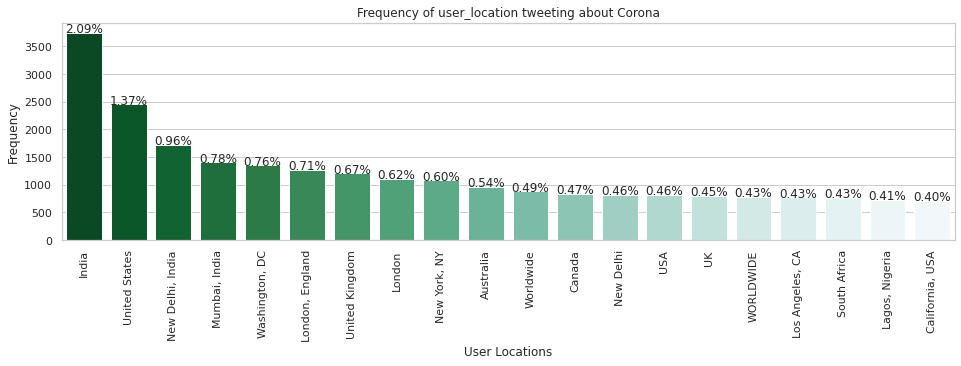

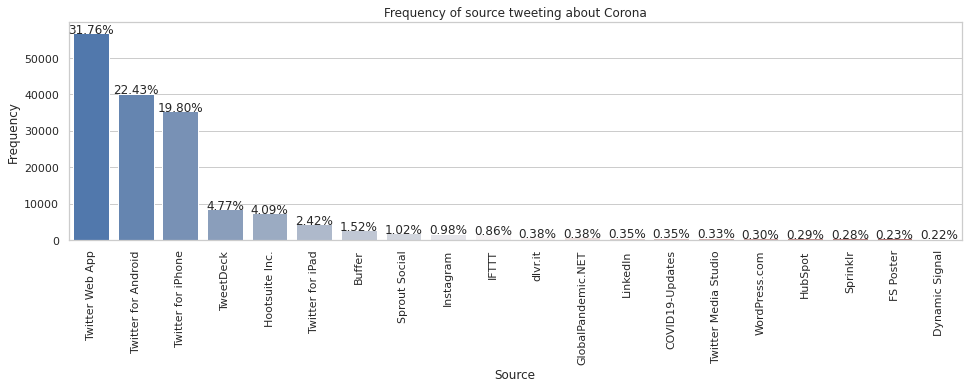

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/content/gdrive/MyDrive/CAPSTONE_PROJECT_SentimentAnalysis/covid19_tweets.csv')
print(df.head())
print(df.tail())
print(df.describe())
print('Shape of tweet dataframe: {}'.format(df.shape))
print(df.info())

# Plot missing values
import seaborn as sns
import matplotlib.pyplot as plt

def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='whitegrid', color_codes=True)
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()
return_missing_values(df)
plot_missing_values(df)

# Heatmap of missing values
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='ocean')
plt.show()

# Plot unique values
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe
udf = return_unique_values(df)
print(udf)

f, ax = plt.subplots(1,1, figsize=(10,5))#plt.figure(figsize=(10, 5))

sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for #unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Frequency of users tweeting about Covid
def plot_frequency_charts(df, feature, title, pallete):
    freq_df = pd.DataFrame()
    freq_df[feature] = df[feature]

    f, ax = plt.subplots(1, 1, figsize=(16, 4))
    total = float(len(df))
    g = sns.countplot(x=df[feature], order=df[feature].value_counts().index[:20], palette=pallete)
    g.set_title("Number and percentage of {}".format(title))

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}%'.format(100 * height / total),
                ha="center")

    plt.title('Frequency of {} tweeting about Corona'.format(feature))
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel(title, fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
plot_frequency_charts(df, 'user_name', 'User Names','Wistia')

# Frequency of locations tweeting about Covid
plot_frequency_charts(df, 'user_location', 'User Locations', 'BuGn_r')

# Frequency of sources tweeting about Covid
plot_frequency_charts(df, 'source','Source', 'vlag')


In [3]:
# Download and install NLTK packages
import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
import re
import string
from string import punctuation
from nltk.corpus import stopwords
# Print stopwords of English to verify packages have downloaded
print(stopwords.words('english')[10:15])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
["you've", "you'll", "you'd", 'your', 'yours']


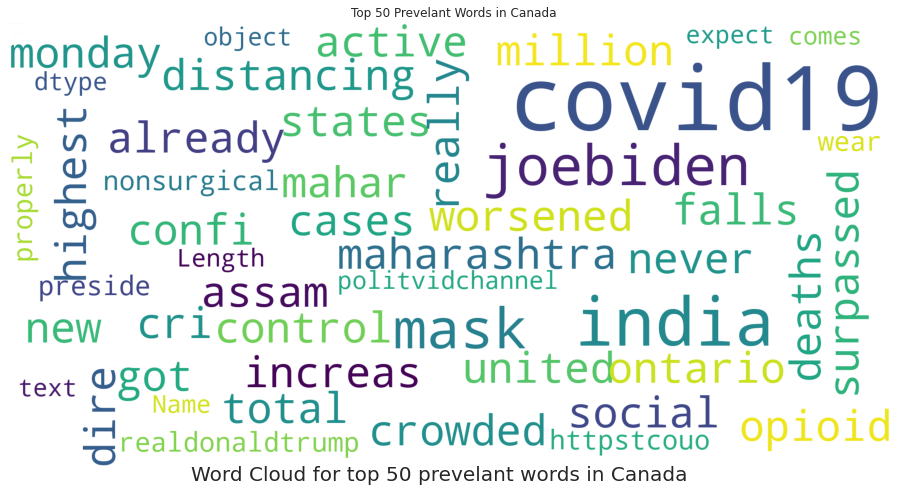

   Unnamed: 0 sentiment                                               text
0        3204       sad  agree the poor in india are treated badly thei...
1        1431       joy  if only i could have spent the with this cutie...
2         654       joy  will nature conservation remain a priority in ...
3        2530       sad  coronavirus disappearing in italy show this to...
4        2296       sad  uk records lowest daily virus death toll since...
Index(['Unnamed: 0', 'sentiment', 'text'], dtype='object')


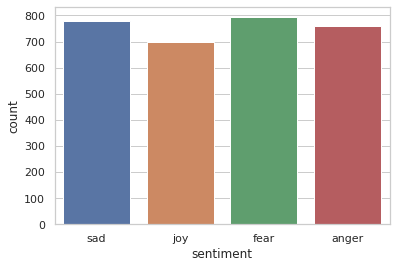

In [4]:
def punctuation_stopwords_removal(sms):
    # filters charecter-by-charecter : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms
# print(df.head())

from collections import Counter

def draw_bar_graph_for_text_visualization(df, location):
    tweets_from_loc = df.loc[df.user_location==location]
    tweets_from_loc.loc[:, 'text'] = tweets_from_loc['text'].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc['text'].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    # Count frequency of words         
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_30_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    # Plot bar chart
    sns.barplot(x='word', y='count',
                data=loc_top_30_words, ax=ax)
    plt.title("Top 50 Prevelant Words in {}".format(location))
    plt.xticks(rotation='vertical');
    
from wordcloud import WordCloud, STOPWORDS

def draw_word_cloud(df, location, title):
    loc_df = df.loc[df.user_location==location]
    # Remove puntuation marks
    loc_df.loc[:, 'text'] = loc_df['text'].apply(punctuation_stopwords_removal)
    # Generate word cloud
    word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df['text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.85)
    plt.imshow(word_cloud)
    plt.show()

draw_bar_graph_for_text_visualization(df, 'Canada')
draw_word_cloud(df, 'Canada', 'Word Cloud for top 50 prevelant words in Canada')

# Sentiment analysis
# Exploring data
sentiment_df = pd.read_csv('/content/gdrive/MyDrive/CAPSTONE_PROJECT_SentimentAnalysis/finalSentimentdata2-Revised.csv')
print(sentiment_df.head())
print(sentiment_df.columns)
# print(sentiment_df['sentiment'].nunique)
sentiment_df.loc[:, 'text'] = sentiment_df['text'].apply(punctuation_stopwords_removal)

sns.countplot(x=sentiment_df['sentiment'])
plt.show()


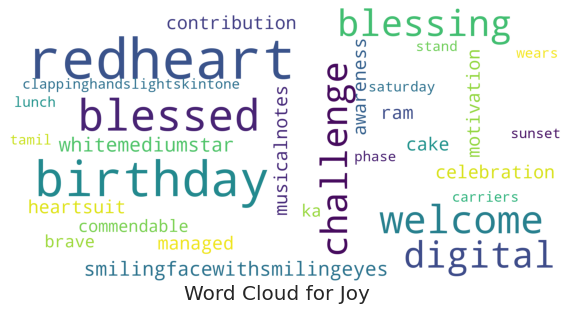

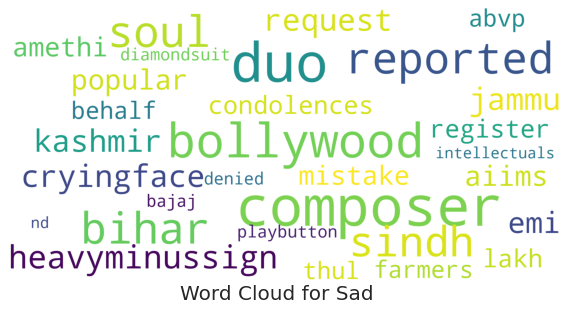

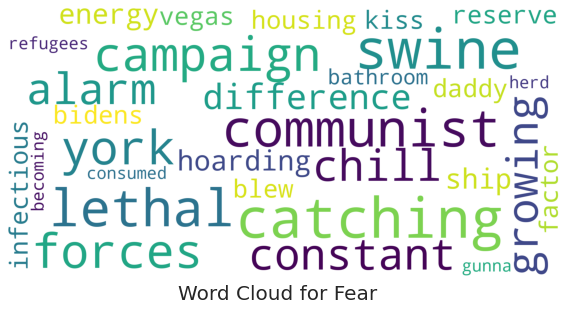

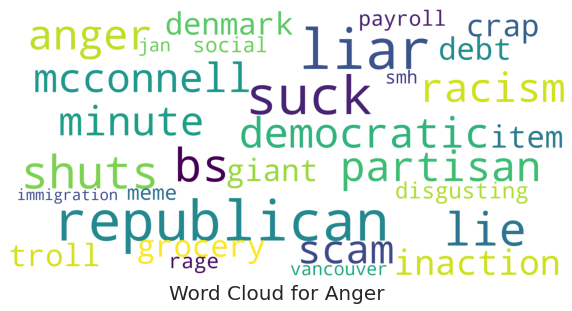

In [5]:
import itertools
def generate_word_cloud(sentiment_label):
  # Extract words for current sentiment
  sentiment_words = sentiment_df.loc[sentiment_df['sentiment']==sentiment_label]['text']
  sentiment_words = [word for text in sentiment_words for word in text]

  # Extract words for other sentiments
  other_sentiments_words = sentiment_df.loc[sentiment_df['sentiment']!=sentiment_label]['text']
  # Use a set for removing duplicated words
  other_sentiments_words = set([word for text in other_sentiments_words for word in text])
  # Remove repeated words in other sentiments (show words unique to current sentiment)
  sentiment_words = [word for word in sentiment_words if word not in other_sentiments_words]

  # print(sentiment_words.head(), end="\n\n")
  word_cloud = WordCloud(background_color='white',
                        stopwords=set(STOPWORDS),
                        max_words=30,
                        max_font_size=40,
                        scale=5,
                        collocations=False,
                        random_state=1).generate(" ".join(sentiment_words))
  fig = plt.figure(1, figsize=(10,10))
  plt.axis('off')
  fig.suptitle(f'Word Cloud for {str.capitalize(sentiment_label)}', fontsize=20)
  fig.subplots_adjust(top=2.22)
  plt.imshow(word_cloud)
  plt.show()

  # Return unique words of sentiment
  return set(sentiment_words)

# Print a word cloud for each sentiment in dataset
sentiments = ["joy", "sad", "fear", "anger"]
unique_words_count = {}
for sentiment_label in sentiments:
  print("\n\n")
  sentiment_words = generate_word_cloud(sentiment_label)
  unique_words_count[sentiment_label] = len(sentiment_words)



Unique words per sentiment: {'joy': 1796, 'sad': 1989, 'fear': 1555, 'anger': 1751}


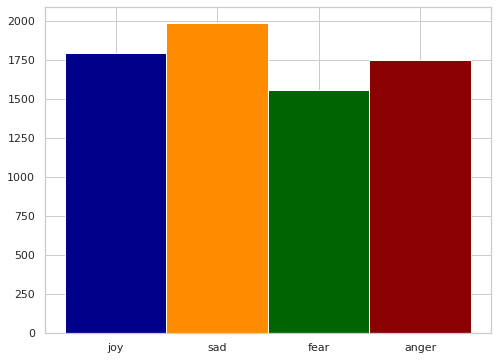

In [6]:
# Create bar chart showing the results of unique words per sentiment
print("\nUnique words per sentiment:", unique_words_count)
plt.figure(figsize=(8, 6))
plt.bar(unique_words_count.keys(), unique_words_count.values(), width=1, color=['darkblue', 'darkorange', 'darkgreen', 'darkred'])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re

# Initialize stemmer
ps=PorterStemmer()
# Initialize lemmatizer
wn=nltk.WordNetLemmatizer()

# Work over a copy of the original dataset
sentiment_tfidf = sentiment_df.copy()
# Exclude a specific sentiment for a more balanced training set
sentiment_tfidf = sentiment_tfidf.drop(sentiment_tfidf[ sentiment_tfidf.sentiment == 'anger' ].index)
sentiment_tfidf = sentiment_tfidf.drop(sentiment_tfidf[ sentiment_tfidf.sentiment == 'fear' ].index)
# Reset indexing, so k-fold don't give issues
sentiment_tfidf = sentiment_tfidf.reset_index()


# Lematize tweets
def lemma(tweet_tokens):
  return [wn.lemmatize(wrd) for wrd in tweet_tokens]

# Extract stemm for each word token
def stemm(tweet_tokens):
    pre_lemm = ''.join([ ps.stem(token) for token in tweet_tokens ])

# Preprocessed and clean tweet text
def process_raw_tweet(tweet_text, stop_words = ()):

    # Remove stop words suchs as articles, prepositions or conjunctions
    tweet_tokens = punctuation_stopwords_removal(tweet_text)

    # Group inflected forms of the same base word using lemmatization
    tweet_tokens = lemma(tweet_tokens)

    # Remove unnecessary puntuation characters
    garbage = "~`!@#$%^&*()_-+={[}]|\:;'<,>.?/"
    return " ".join([char for char in tweet_tokens if char not in garbage])

    #Stemming
    tweet_tokens = stemm(tweet_tokens)


for index, row in sentiment_tfidf.iterrows():
  # Join tokenized words into a single string of text
  tweet_text = " ".join(row.text)
  sentiment_tfidf.text[index] = process_raw_tweet(tweet_text)
  # Encode sentiments into two categories: 0 (negative, ex: sad) or 1 (positive, ex: joy)
  sentiment_tfidf.sentiment[index] = ('1' if row.sentiment == 'joy' else '0')


In [14]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

print("Total number of samples: ", len(sentiment_tfidf), end="\n\n")

# Split the data intro training and testing sets using K-Fold approach
folds = StratifiedKFold(n_splits=5)
for train_index, test_index in folds.split(sentiment_tfidf['text'],sentiment_tfidf['sentiment']):
    X_train, X_test, y_train, y_test = sentiment_tfidf['text'][train_index], sentiment_tfidf['text'][test_index], \
    sentiment_tfidf['sentiment'][train_index], sentiment_tfidf['sentiment'][test_index]

def vectorize_train_test_data(vectorizer):
  t = time()  # mark start time of model training
  X_train_tf = vectorizer.fit_transform(X_train)

  duration = time() - t
  print("\nTime taken to extract features from *training* data : %f seconds" % (duration))
  print("n_samples: %d, n_features: %d" % X_train_tf.shape)

  '''
  Transforming test data into tfidf-vectorized matrix
  '''
  t = time()
  X_test_tf = vectorizer.transform(X_test)

  duration = time() - t
  print("Time taken to extract features from *test* data : %f seconds" % (duration))
  print("n_samples: %d, n_features: %d" % X_test_tf.shape)

  return X_train_tf, X_test_tf


def train_test_naiveBayes(X_train_tf, X_test_tf):
  global y_train, y_pred

  '''
  Applying Naive Bayes
  '''
  # build naive bayes classification model
  t = time()

  classifier = MultinomialNB()
  classifier.fit(X_train_tf, y_train)

  training_time = time() - t
  print("\ntrain time: %0.3fs" % training_time)

  '''
  Calculating accuracy and generating classification report from test data
  '''
  # predict the new document from the testing dataset
  t = time()
  y_pred = classifier.predict(X_test_tf)

  test_time = time() - t
  print("test time:  %0.3fs" % test_time)

  # compute the performance measures
  score1 = metrics.accuracy_score(y_test, y_pred)
  print("accuracy:   %0.3f" % score1, end="\n\n")

  print(metrics.classification_report(y_test, y_pred, target_names=['negative', 'positive']))

  print("# Confusion Matrix")
  # print(metrics.confusion_matrix(y_test, y_pred))
  cmtx = pd.DataFrame(
      metrics.confusion_matrix(y_test, y_pred, labels=['0', '1']), 
      index=['true:negative', 'true:positive'], 
      columns=['pred:negative', 'pred:positive']
  )
  print(cmtx)

  return classifier, score1, y_pred

'''
Applying tfidf vectorizer
'''
n_gram_size = (3, 2, 1) # try unigram, bigram and trigram
benchmark_data = []
for n in n_gram_size:
  print(f"##### Using gram size of {n} #########\n")
  # Testing TD-IDF vectorizer
  print("## TF-IDF vectorizer ##")
  tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(n, n)) # or term frequency
  X_train_tf, X_test_tf = vectorize_train_test_data(tfidf_vectorizer)
  classifier, score, y_pred = train_test_naiveBayes(X_train_tf, X_test_tf)
  benchmark_data.append({ 'gram_size': n, 'score': score, 'classifier': classifier, 'vectorizer': tfidf_vectorizer, 'predictions': y_pred})

  # Testing count vectorizer
  print("\n\n## Count vectorizer ##")
  count_vectorizer = CountVectorizer(min_df=2, max_df=0.5, ngram_range = (n,n))
  X_train_tf, X_test_tf = vectorize_train_test_data(count_vectorizer)
  classifier, score, y_pred = train_test_naiveBayes(X_train_tf, X_test_tf)
  benchmark_data.append({ 'gram_size': n, 'score': score, 'classifier': classifier, 'vectorizer': count_vectorizer, 'predictions': y_pred})

  print("\n\n")

print("###################################\n")
# print("== Summary ==")
best_model = max(benchmark_data, key=lambda x: x['score'])
print(f"The BEST SCORE of {best_model['score']} is achieved using {best_model['vectorizer'].__class__.__name__} with Gram Size of {best_model['gram_size']}")
# Select best vectorizer and classifier based on score
vectorizer = best_model['vectorizer']
classifier = best_model['classifier']
y_pred = best_model['predictions']

print("\n\n## The following are False Negative (FN) Tweets: ##\n")
i = 0
for key in y_test.index:
  if y_test[key]=="1" and y_pred[i]=="0":
       print("-", X_test[key])
  i += 1
        
#Finding the first five False Psitive Tweets
print("\n\n## The following are False Positive (FP) Tweets: ##\n")
i = 0
for key in y_test.index:
  if y_test[key]=="0" and y_pred[i]=="1":
       print("-", X_test[key])
  i += 1

Total number of samples:  1478

##### Using gram size of 3 #########

## TF-IDF vectorizer ##

Time taken to extract features from *training* data : 0.068976 seconds
n_samples: 1183, n_features: 596
Time taken to extract features from *test* data : 0.008631 seconds
n_samples: 295, n_features: 596

train time: 0.003s
test time:  0.000s
accuracy:   0.559

              precision    recall  f1-score   support

    negative       0.54      1.00      0.70       155
    positive       1.00      0.07      0.13       140

    accuracy                           0.56       295
   macro avg       0.77      0.54      0.42       295
weighted avg       0.76      0.56      0.43       295

# Confusion Matrix
               pred:negative  pred:positive
true:negative            155              0
true:positive            130             10


## Count vectorizer ##

Time taken to extract features from *training* data : 0.061478 seconds
n_samples: 1183, n_features: 596
Time taken to extract features from 

In [9]:
# Function for cleaning up and preparing a tweet text, and then predicting its sentiment
def predict_covid_sentiment(custom_tweet, printing=True):
    # Clean-up and normalize raw tweet
    processed_tweet = process_raw_tweet(custom_tweet)
    # Encode tweet using TF/IDF
    encoded_tweet = vectorizer.transform([processed_tweet])
    # Predict sentiment (0: negative or 1:positive)
    sentiments_labels = ('negative', 'positive')
    encoded_sentiment = classifier.predict(encoded_tweet)[0]
    # Decode sentiment, 0 is negative and 1 is positive
    sentiment = sentiments_labels[int(encoded_sentiment)]
    # Print results
    if printing:
      print(custom_tweet, " -- ", sentiment, end="\n\n")

    return sentiment

print('------------------------------\n')
## Predict made up tweets related to COVID to test model behaviour ##
test_tweet_1 = 'Wow. That is amazing. But if this could happen in Canada, that would be great!'
predict_covid_sentiment(test_tweet_1)
test_tweet_2 = 'I do not think this could work, it needs more test at least.'
predict_covid_sentiment(test_tweet_2)
test_tweet_3 = 'It is very sad to see the corona pandemic increasing at such an alarming rate'
predict_covid_sentiment(test_tweet_3)
test_tweet_4 = 'It is amazing to see that New Zealand reaches 100 days without Covid transmission!'
predict_covid_sentiment(test_tweet_4)
test_tweet_5 = 'It was good to see this thing.'
predict_covid_sentiment(test_tweet_5)
test_tweet_6 = 'That is not predictable.'
predict_covid_sentiment(test_tweet_6)
test_tweet_7 = 'Trump must pay more attention to covid.'
predict_covid_sentiment(test_tweet_7)
test_tweet_8 = 'Vaccination is ramping up but still a long way to go before we can return to normal life.'
predict_covid_sentiment(test_tweet_8)

print("----------------------------")

------------------------------

Wow. That is amazing. But if this could happen in Canada, that would be great!  --  positive

I do not think this could work, it needs more test at least.  --  negative

It is very sad to see the corona pandemic increasing at such an alarming rate  --  negative

It is amazing to see that New Zealand reaches 100 days without Covid transmission!  --  positive

It was good to see this thing.  --  positive

That is not predictable.  --  negative

Trump must pay more attention to covid.  --  negative

Vaccination is ramping up but still a long way to go before we can return to normal life.  --  negative

----------------------------


In [10]:
import base64
import requests
import json

class TwitterAPIConnector:
  base_url = 'https://api.twitter.com/'

  def __init__(self):
    self.access_token = self.tweeter_api_connect()

  def tweeter_api_connect(self):
    #Define your keys from the developer portal
    client_key = 'oDbi8WWs4nYVRofeI5wSCJ0nM'
    client_secret = 'eJ0f2abCzastt3zr1PfFsLVaixmFfyKkTOpfADWM6LlAfFMepB'
    #Reformat the keys and encode them
    # we start in unicode and then transform to bytes
    key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
    # Transform from bytes to bytes that can be printed
    b64_encoded_key = base64.b64encode(key_secret)
    #Transform from bytes back into Unicode
    b64_encoded_key = b64_encoded_key.decode('ascii')  

    # Prepare request
    auth_url = '{}oauth2/token'.format(self.base_url)
    auth_headers = {
        'Authorization': 'Basic {}'.format(b64_encoded_key),
        'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
    }
    auth_data = {
        'grant_type': 'client_credentials'
    }
    auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)

    # Extract and return access token to be used in subsequent API requests
    access_token = auth_resp.json()['access_token']
    return access_token

  def fetch_latest_tweets(self, search_term, number):
    search_headers = {
      'Authorization': 'Bearer {}'.format(self.access_token)    
    }
    # Build search parameters to look for recent tweets related to the provided search term (COVID vaccines)
    search_params = {
        'q': search_term,
        'result_type': 'recent', # Most recent tweets
        # 'geocode': '43.6621082,-79.4551756,100km',   # Search in GTA
        'geocode': '44.894837921524676,-79.66640093770677,250km',   # Search in the GTA and neighboring cities
        'lang': 'en', # Only on English language
        'count': number * 3, # Fetch additional tweets in case of duplicity
        'tweet_mode': 'extended' # Fetch full text
    }


    search_url = '{}1.1/search/tweets.json'.format(self.base_url)
    # Make request to Tweeter API
    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
    # Transform and extract contents of the response
    Data = json.loads( search_resp.content )
    statuses = np.array(Data['statuses']) 

    # Extract full tweets from tweet or retweet if available
    tweets_text = [ tweet['retweeted_status']['full_text'] if 'retweeted_status' in tweet else tweet['full_text'] for tweet in statuses ]
    # Remove duplicated tweets
    tweets_text, indexes = np.unique(tweets_text, return_index=True)

    return tweets_text[:number], statuses[indexes][:number] # Show at most the number of specified tweets


# Connect and authenticate with Twitter API
tweeter_connector = TwitterAPIConnector()

Showing first 15 tweets
1. "We are seeing a rapidly deteriorating situation with a record number of COVID cases and hospital admissions threatening to overwhelm our health care system.” -Premier Ford. ☎️Peel Education workers in hot spots: provincial vaccine booking 1‑833‑943‑3900  -->  [ NEGATIVE ]

2. COVID-19 vaccines have been found to be extremely safe and effective for olderadults, and the majority of the older people in the US, UK and Israel have received theirs. Find out more in our updated COVID-19 Vaccine Q&amp;A Pamphlet  -->  [ POSITIVE ]

3. Vaccine side effects mean your immune system is working and doing what it’s supposed to do: working and building up protection against this virus. Get your vaccine questions answered in our updated COVID-19 Vaccine Q&amp;A for Older Canadians  -->  [ NEGATIVE ]

4. 5/✅I want this pandemic to be over ⠀ ✅I have consumed a bar mat shot, which was definitely worse for my health than a COVID-Vaccine ⠀ ✅I want to help minimize the PTSD and b

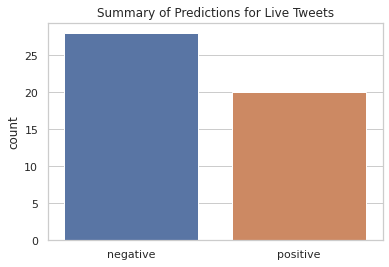

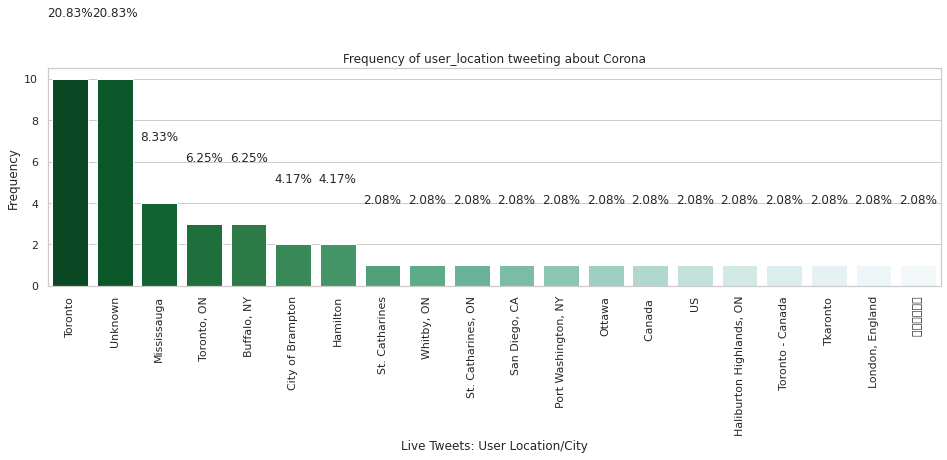

In [13]:
# Remove unused garnish from tweet, extracting only the text itself before predicting sentiment analysis 
def clean_tweet(tweet_text):
    # Remove urls
    tweet_text = re.sub(r"http\S+|www\S+|https\S+", '', tweet_text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet_text
    tweet_text = re.sub(r'\@\w+|\#','', tweet_text)

    # Remove extra spacing
    tweet_text = re.sub(r'\s+', ' ', tweet_text)
    tweet_text = str.strip(tweet_text)
    return tweet_text

# Fetch latest tweets by keywords covid and vaccine
raw_tweets_text, tweets_statuses = tweeter_connector.fetch_latest_tweets('covid,vaccine', 50)

sentimentsList = []
print("Showing first 15 tweets")
for i in range(len(raw_tweets_text)): 
  custom_tweet = raw_tweets_text[i]
  # Get rid of hashtag and URL
  cleaned_tweet = clean_tweet(custom_tweet)
  # Predict the sentiment
  sentiment = predict_covid_sentiment(cleaned_tweet, False)
  # Show tweet text and sentiment prediction
  if i < 15: # Show displays the first 15 tweets
    print(f"{i+1}. {cleaned_tweet}", " --> ", f"[ {str.upper(sentiment)} ]", end="\n\n")

  # Collect predicted sentiment for statistical analysis
  sentimentsList.append(sentiment)

from collections import Counter
# Count number of tweets for each sentiment
stats = dict(Counter(sentimentsList))
print("-------------------\n")
print("Summary: ", stats, "\n")

# Plotting results as a barchart
g = sns.countplot(x=sentimentsList)
g.set_title("Summary of Predictions for Live Tweets")
plt.show()

print("\n\n\n")
# Extract the location of the user who made the tweet, and remove state and country to be able to cluster similar locations 
live_df = pd.DataFrame(data=[{'user_location': status['user']['location'].replace(", Ontario", "").replace(", Canada", "") if status['user']['location'] else 'Unknown' } for status in tweets_statuses])
# Plot a frequency chart for the cities/locations where the tweets come from.
plot_frequency_charts(live_df, 'user_location', 'Live Tweets: User Location/City', 'BuGn_r')